# ⚡ XGBoost Models for Drug Sensitivity Prediction

This notebook trains an **XGBoost regression model per drug** using gene expression features. XGBoost is widely used for structured data due to its speed, regularization, and strong predictive performance. We use **5-fold cross-validation** to evaluate model generalization with both RMSE and R² scores.


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/processed/bulk_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 33)


### 🔁 Train One XGBoost Model Per Drug

For each drug, we train a separate XGBoost regressor using its associated (cell line, IC50, features) data. Performance is evaluated using RMSE and R².


In [3]:
os.makedirs("xgb/models", exist_ok=True)
os.makedirs("xgb/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipping drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    '''model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )'''

    model = xgb.XGBRegressor(
    n_estimators=100,         # Increased rounds (can go to 300 if needed)
    max_depth=4,              # Shallower trees are safer with high-dim data
    learning_rate=0.05,       # Slower learning = safer generalization
    subsample=0.8,            # Sample rows
    colsample_bytree=0.2,     # Sample only 30% of columns per tree (≅ 900 features)
    reg_alpha=1.0,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization
    n_jobs=4,
    random_state=42,
    verbosity=0
)


    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n💊 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)

    #joblib.dump(model, f"xgb/models/xgb_drug_{drug_id}.pkl")



💊 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.2788 0.7809 1.1172 0.942  1.0299] | Mean: 1.0297 ± 0.1669
  ➤ R²   (folds): [ 0.117   0.136   0.0726  0.2288 -0.0228] | Mean: 0.1063 ± 0.0823

💊 Drug 3 | Samples: 356
  ➤ RMSE (folds): [1.9643 1.779  2.0151 1.989  2.0535] | Mean: 1.9602 ± 0.0953
  ➤ R²   (folds): [-0.065   0.0693 -0.0026  0.0584  0.0982] | Mean: 0.0317 ± 0.0584

💊 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.4401 1.4008 1.8426 1.3612 1.3755] | Mean: 1.4841 ± 0.1813
  ➤ R²   (folds): [0.2065 0.2359 0.1348 0.2149 0.0135] | Mean: 0.1611 ± 0.0813

💊 Drug 6 | Samples: 403
  ➤ RMSE (folds): [1.1618 0.6938 0.8925 0.8192 0.8811] | Mean: 0.8897 ± 0.1533
  ➤ R²   (folds): [-0.1291  0.1024  0.0605 -0.1939  0.0446] | Mean: -0.0231 ± 0.1164

💊 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.4764 1.4228 1.44   1.448  1.3869] | Mean: 1.4348 ± 0.0296
  ➤ R²   (folds): [ 0.0729  0.0476 -0.0928  0.0932  0.0372] | Mean: 0.0316 ± 0.0652

💊 Drug 11 | Samples: 393
  ➤ RMSE (folds): [1.8629 1.8628 2.086

In [4]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/xgboost/voom_30_pcs.csv", index=False)

print("📁 Saved to xgb/results/model_performance_summary.csv")
results_df.head()


📁 Saved to xgb/results/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.029740,0.166906,0.106319,0.082252
1,3,356,1.960197,0.095294,0.031668,0.058418
2,5,394,1.484053,0.181260,0.161122,0.081263
3,6,403,0.889674,0.153262,-0.023101,0.116401
4,9,396,1.434828,0.029573,0.031622,0.065226


### 📊 Distribution of XGBoost Model Performance

These plots visualize the RMSE and R² across all drug-specific models trained using XGBoost.


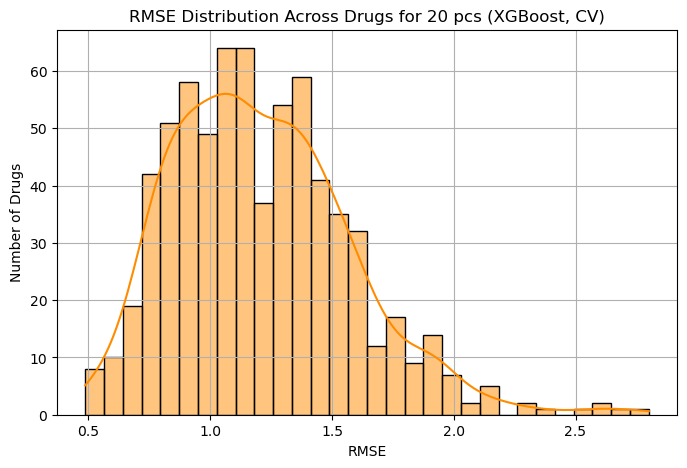

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (XGBoost, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"xgb/results/rmse_comparison_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

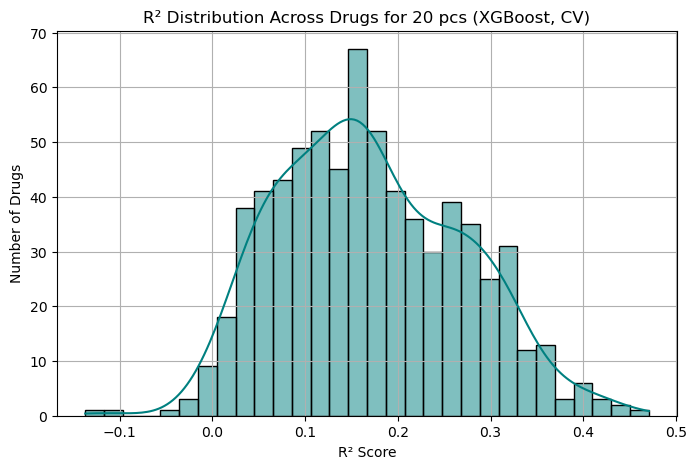

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (XGBoost, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"xgb/results/r2_comparison_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()